# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from tqdm import tqdm

# Load Dataset

In [3]:
df = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/train.csv")

In [4]:
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


# Visualizing Image Samples

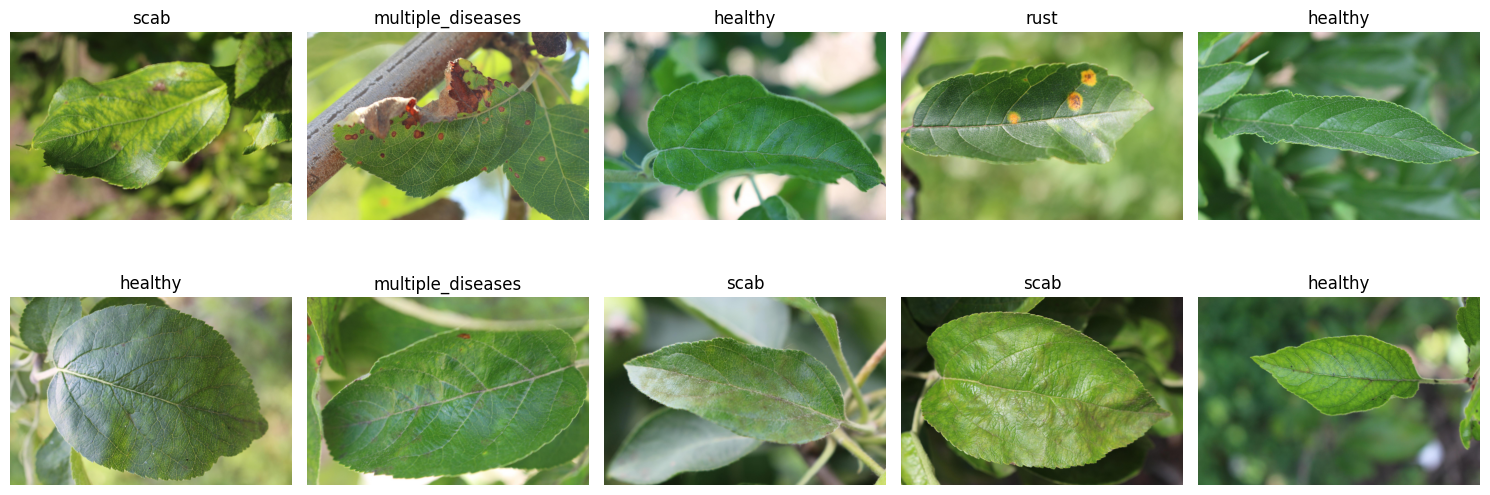

In [5]:
import matplotlib.image as mpimg
image_dir = "/kaggle/input/plant-pathology-2020-fgvc7/images/"
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    img_path = os.path.join(image_dir, df.loc[i, 'image_id'] + ".jpg")
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(df.columns[1:][df.iloc[i, 1:].values == 1][0])
    ax.axis("off")
plt.tight_layout()
plt.show()

# Converting Labels to Single Category


In [6]:
df['label'] = df[df.columns[1:5]].idxmax(axis=1)
df = df[['image_id', 'label']]
df.head()

,image_id,label
0,Train_0,scab
1,Train_1,multiple_diseases
2,Train_2,healthy
3,Train_3,rust
4,Train_4,healthy


# Class Distribution

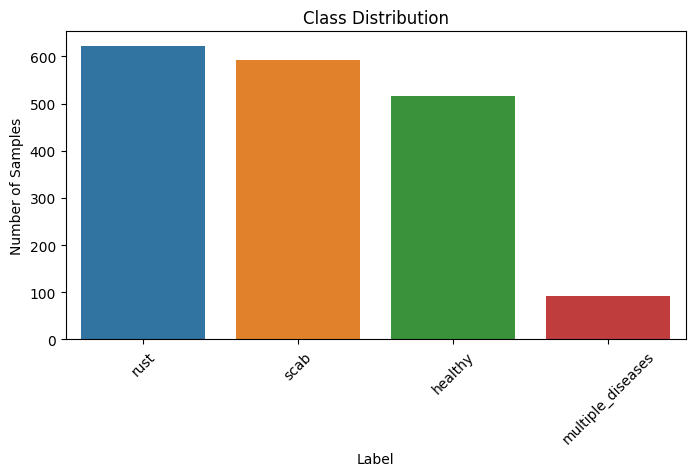

In [7]:
label_counts = df['label'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Class Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.show()

# Image Size Distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


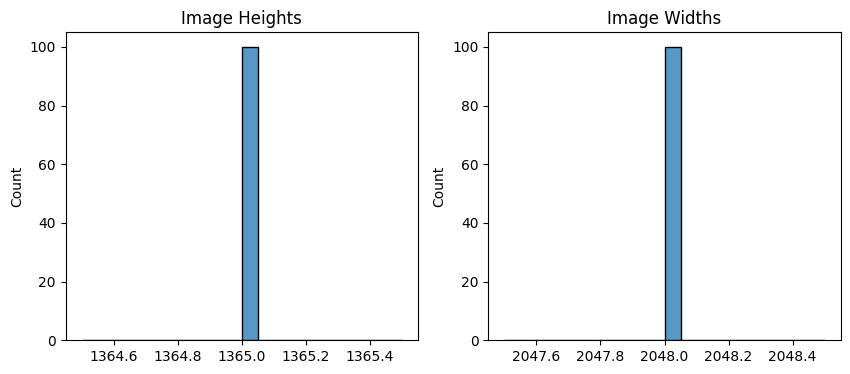

In [8]:
widths, heights = [], []
for i in range(100): 
    img_path = os.path.join(image_dir, df.iloc[i]['image_id'] + ".jpg")
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    heights.append(h)
    widths.append(w)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(heights, bins=20)
plt.title("Image Heights")
plt.subplot(1,2,2)
sns.histplot(widths, bins=20)
plt.title("Image Widths")
plt.show()

 # Average RGB Values Per Class

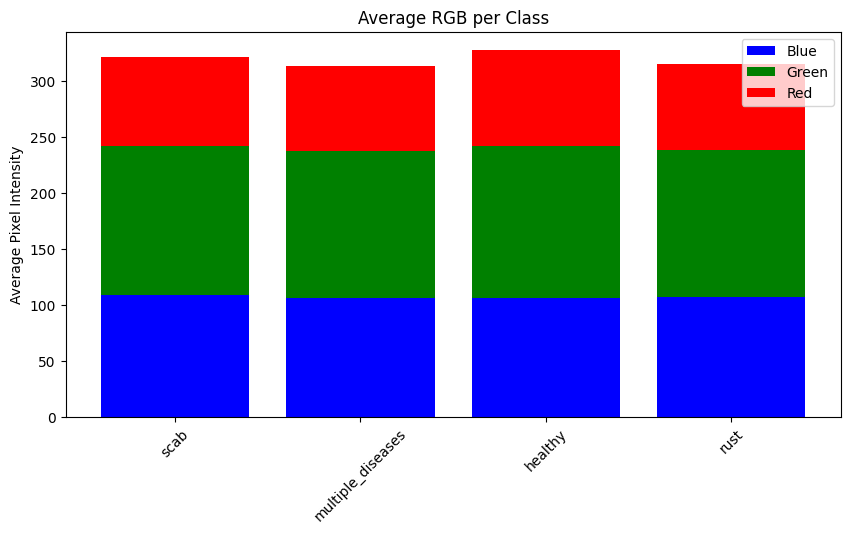

In [9]:
class_colors = {label: [] for label in df['label'].unique()}
sample_per_class = 20
for label in class_colors:
    samples = df[df['label'] == label].sample(sample_per_class, random_state=42)
    for image_id in samples['image_id']:
        img = cv2.imread(os.path.join(image_dir, image_id + ".jpg"))
        img = cv2.resize(img, (128, 128))
        avg_color = img.mean(axis=(0,1))
        class_colors[label].append(avg_color)
plt.figure(figsize=(10,5))
for label, colors in class_colors.items():
    avg_rgb = np.mean(colors, axis=0)
    plt.bar(label, avg_rgb[2], color='b', label='Blue' if label==list(class_colors.keys())[0] else "")
    plt.bar(label, avg_rgb[1], color='g', bottom=avg_rgb[2], label='Green' if label==list(class_colors.keys())[0] else "")
    plt.bar(label, avg_rgb[0], color='r', bottom=avg_rgb[2]+avg_rgb[1], label='Red' if label==list(class_colors.keys())[0] else "")
plt.title("Average RGB per Class")
plt.legend()
plt.xticks(rotation=45)
plt.ylabel("Average Pixel Intensity")
plt.show()

# Confirming All Images Are Color

In [10]:
gray_images = 0
for i in range(50):
    img_path = os.path.join(image_dir, df.iloc[i]['image_id'] + ".jpg")
    img = cv2.imread(img_path)
    if img.shape[2] != 3:
        gray_images += 1
print(f"Out of 50 checked images, {gray_images} are grayscale.")

Out of 50 checked images, 0 are grayscale.


# Feature Extraction

In [11]:
def extract_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist_r = cv2.calcHist([img], [0], None, [32], [0, 256]).flatten()
    hist_g = cv2.calcHist([img], [1], None, [32], [0, 256]).flatten()
    hist_b = cv2.calcHist([img], [2], None, [32], [0, 256]).flatten()
    color_features = np.concatenate([hist_r, hist_g, hist_b])
    gray_scaled = (gray / 4).astype(np.uint8)  # Scale to 64 levels
    glcm = graycomatrix(gray_scaled, distances=[1], angles=[0], levels=64, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    texture_features = [contrast, correlation, energy, homogeneity]
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(c)
        perimeter = cv2.arcLength(c, True)
    else:
        area, perimeter = 0, 0
    shape_features = [area, perimeter]
    return np.concatenate([color_features, texture_features, shape_features])

#  Extracting Features for All Images

In [12]:
features = []
labels = []
for i in tqdm(range(len(df))):
    image_id = df.iloc[i]['image_id']
    label = df.iloc[i]['label']
    path = os.path.join(image_dir, image_id + ".jpg")
    feats = extract_features(path)
    features.append(feats)
    labels.append(label)
X = np.array(features)
y = np.array(labels)
print("Feature shape:", X.shape)

100%|██████████| 1821/1821 [00:30<00:00, 60.05it/s]

Feature shape: (1821, 102)


# Encoding Labels and Scaling Features

In [13]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Train-Test Spliting

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

 # Training Support Vector Machine

In [15]:
svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

SVM Accuracy: 0.5561643835616439
                   precision    recall  f1-score   support

          healthy       0.66      0.59      0.62       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.52      0.51      0.52       125
             scab       0.52      0.66      0.58       119

         accuracy                           0.56       365
        macro avg       0.42      0.44      0.43       365
     weighted avg       0.53      0.56      0.54       365



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Learning Curve For SVM

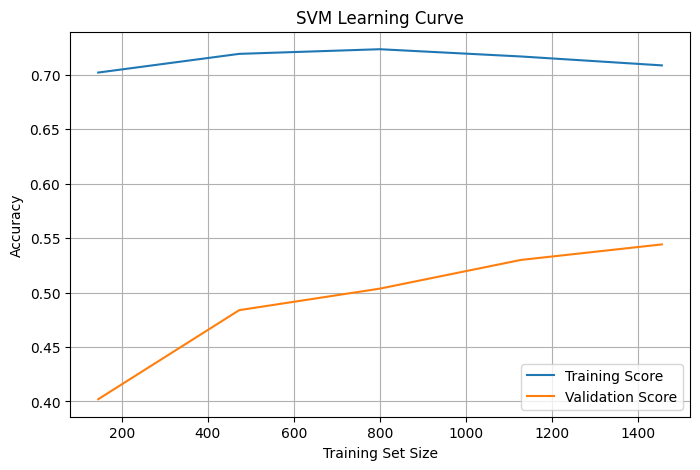

In [16]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    SVC(kernel='rbf', C=1),
    X_scaled,
    y_encoded,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, val_mean, label='Validation Score')
plt.title("SVM Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Training Random Forest

In [17]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

Random Forest Accuracy: 0.6301369863013698
                   precision    recall  f1-score   support

          healthy       0.63      0.57      0.60       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.62      0.70      0.66       125
             scab       0.64      0.70      0.67       119

         accuracy                           0.63       365
        macro avg       0.47      0.49      0.48       365
     weighted avg       0.60      0.63      0.61       365



# Learning Curve for Random Forest

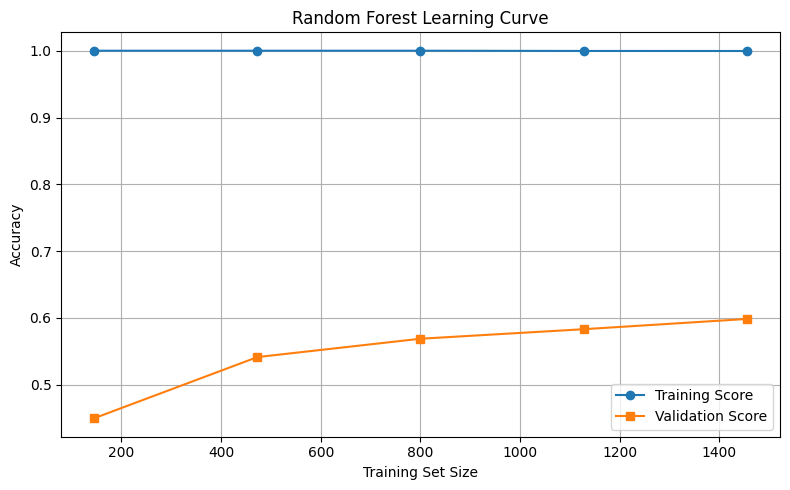

In [18]:
train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(
    RandomForestClassifier(n_estimators=200, random_state=42),
    X_scaled,
    y_encoded,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy',
    n_jobs=-1
)
train_mean_rf = train_scores_rf.mean(axis=1)
val_mean_rf = val_scores_rf.mean(axis=1)
plt.figure(figsize=(8,5))
plt.plot(train_sizes_rf, train_mean_rf, label='Training Score', marker='o')
plt.plot(train_sizes_rf, val_mean_rf, label='Validation Score', marker='s')
plt.title("Random Forest Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Training XGBoost

In [19]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

XGBoost Accuracy: 0.6383561643835617
                   precision    recall  f1-score   support

          healthy       0.62      0.62      0.62       103
multiple_diseases       0.50      0.06      0.10        18
             rust       0.63      0.71      0.67       125
             scab       0.66      0.66      0.66       119

         accuracy                           0.64       365
        macro avg       0.60      0.51      0.51       365
     weighted avg       0.63      0.64      0.63       365



# Learning Curve for XGBoost

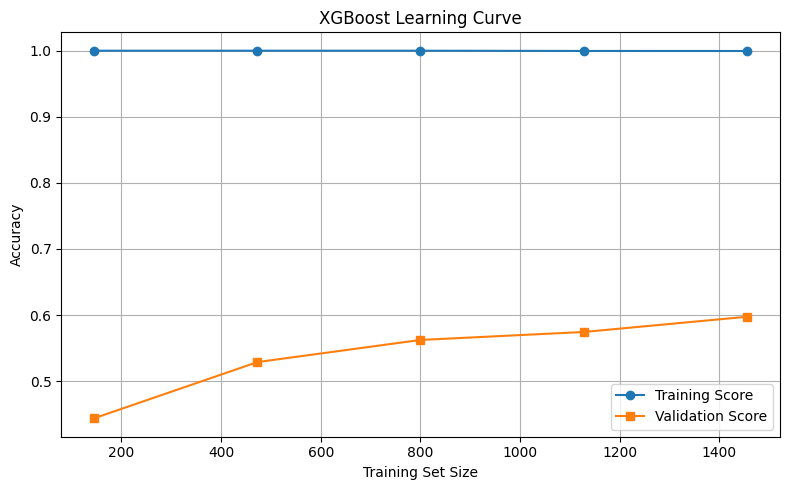

In [20]:
train_sizes, train_scores, val_scores = learning_curve(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    X_scaled,
    y_encoded,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy',
    n_jobs=-1
)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score', marker='o')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation Score', marker='s')
plt.title("XGBoost Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrices

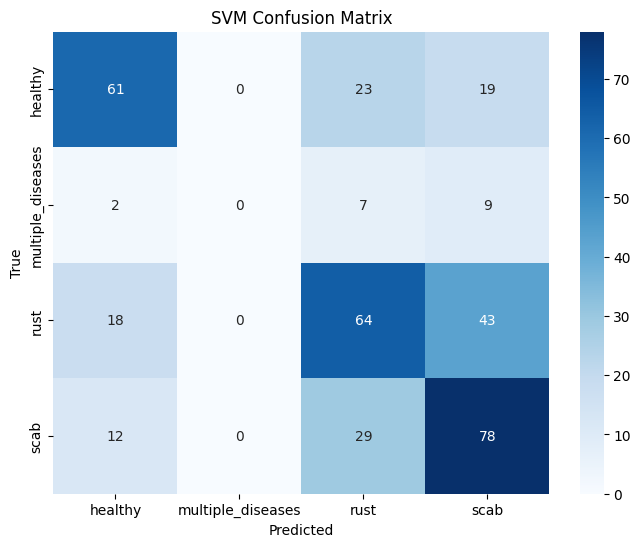

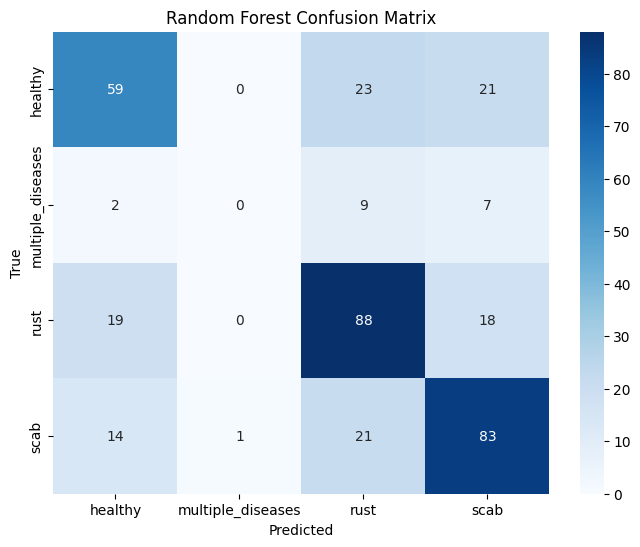

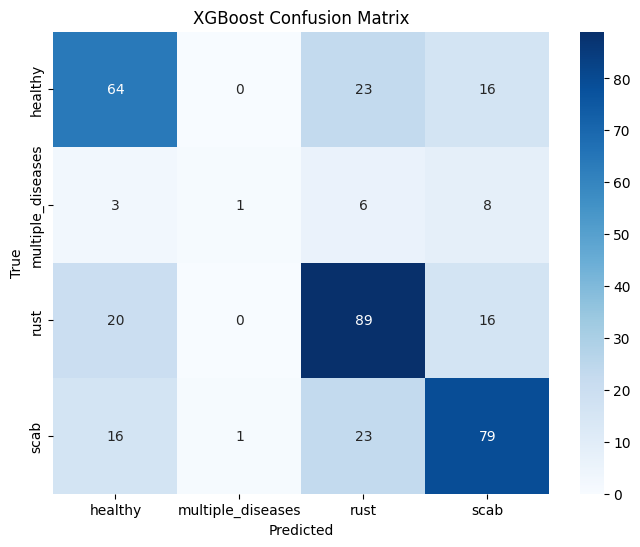

In [21]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_cm(y_test, y_pred_svm, "SVM Confusion Matrix")
plot_cm(y_test, y_pred_rf, "Random Forest Confusion Matrix")
plot_cm(y_test, y_pred_xgb, "XGBoost Confusion Matrix")

#  Cross Validation Comparison

In [22]:
models = {
    'SVM': SVC(kernel='rbf', C=1, gamma='scale'),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y_encoded, cv=5, scoring='accuracy')
    print(f"{name} - Mean Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

SVM - Mean Accuracy: 0.5458 (+/- 0.0205)
Random Forest - Mean Accuracy: 0.5942 (+/- 0.0176)
XGBoost - Mean Accuracy: 0.5694 (+/- 0.0257)


# **Predictions on Random Images**

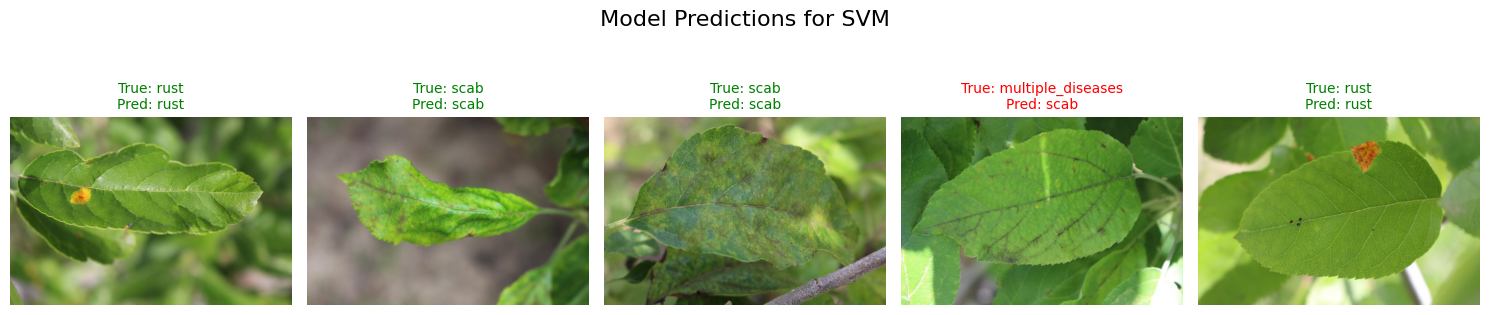

In [23]:
import random
n_samples = 5
plt.figure(figsize=(15, 8))
for i in range(n_samples):
    idx = random.randint(0, len(df) - 1)
    image_id = df.iloc[idx]['image_id']
    true_label = df.iloc[idx]['label']
    img_path = os.path.join(image_dir, image_id + ".jpg")
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    features = extract_features(img_path)
    features_scaled = scaler.transform([features])
    pred_encoded = svm.predict(features_scaled)[0]
    pred_label = le.inverse_transform([pred_encoded])[0]
    color = 'green' if pred_label == true_label else 'red'
    title = f"True: {true_label}\nPred: {pred_label}"
    plt.subplot(1, n_samples, i + 1)
    plt.imshow(img_rgb)
    plt.title(title, fontsize=10, color=color)
    plt.axis('off')
plt.suptitle(" Model Predictions for SVM ", fontsize=16, y=0.73)
plt.tight_layout()
plt.show()

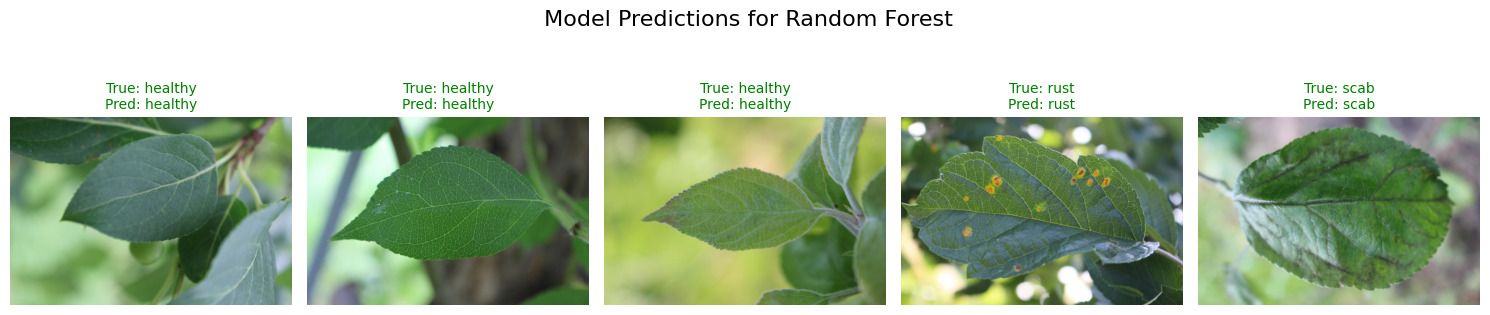

In [24]:
import random
n_samples = 5
plt.figure(figsize=(15, 8))
for i in range(n_samples):
    idx = random.randint(0, len(df) - 1)
    image_id = df.iloc[idx]['image_id']
    true_label = df.iloc[idx]['label']
    img_path = os.path.join(image_dir, image_id + ".jpg")
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    features = extract_features(img_path)
    features_scaled = scaler.transform([features])
    pred_encoded = rf.predict(features_scaled)[0]
    pred_label = le.inverse_transform([pred_encoded])[0]
    color = 'green' if pred_label == true_label else 'red'
    title = f"True: {true_label}\nPred: {pred_label}"
    plt.subplot(1, n_samples, i + 1)
    plt.imshow(img_rgb)
    plt.title(title, fontsize=10, color=color)
    plt.axis('off')
plt.suptitle(" Model Predictions for Random Forest", fontsize=16, y=0.73)
plt.tight_layout()
plt.show()

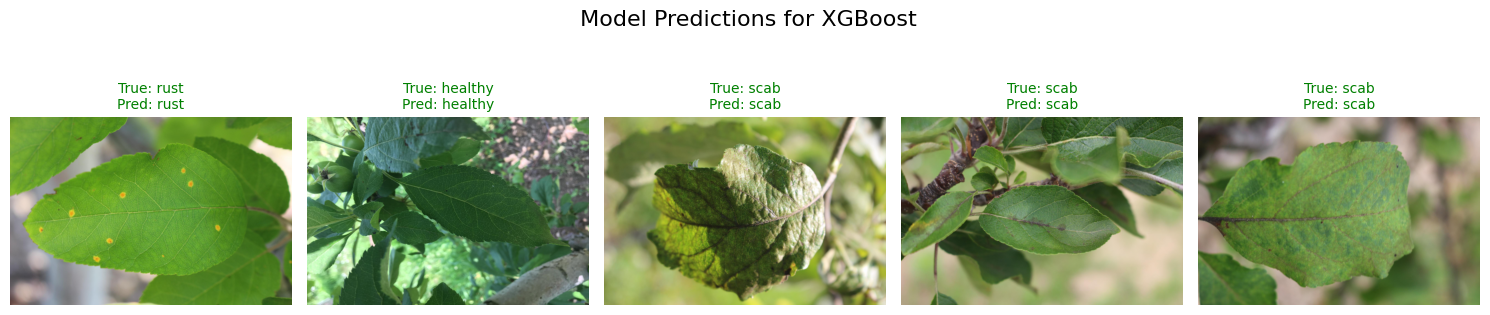

In [25]:
import random
n_samples = 5
plt.figure(figsize=(15, 8))
for i in range(n_samples):
    idx = random.randint(0, len(df) - 1)
    image_id = df.iloc[idx]['image_id']
    true_label = df.iloc[idx]['label']
    img_path = os.path.join(image_dir, image_id + ".jpg")
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    features = extract_features(img_path)
    features_scaled = scaler.transform([features])
    pred_encoded = xgb.predict(features_scaled)[0]
    pred_label = le.inverse_transform([pred_encoded])[0]
    color = 'green' if pred_label == true_label else 'red'
    title = f"True: {true_label}\nPred: {pred_label}"
    plt.subplot(1, n_samples, i + 1)
    plt.imshow(img_rgb)
    plt.title(title, fontsize=10, color=color)
    plt.axis('off')
plt.suptitle(" Model Predictions for XGBoost", fontsize=16, y=0.73)
plt.tight_layout()
plt.show()